In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import chain
from model.SVD_Label import SVD_Label
from model.NMF_Label import NMF_Label
from model.WE_Label import WE_Label

# Setting 

In [2]:
FD_DATA = './data/'
FD_WEIGHT = './weight_dbg/'
FN_DATA = FD_DATA + 'data_sample.csv'
# FN_WEIGHT = FD_WEIGHT + 'weight_SVD.p'
# FN_WEIGHT = FD_WEIGHT + 'weight_NMF.p'
# FN_WEIGHT = FD_WEIGHT + 'weight_WE.p'

# Load Data

In [3]:
df = pd.read_csv(FN_DATA, encoding='latin-1')
N = df.shape[0]

# Map label to label description 
map_l2d = dict(df.groupby(by='LABEL')['LABEL_DESC'].first().reset_index().values.tolist())

df.columns, N

(Index(['DESC', 'LABEL', 'LABEL_DESC'], dtype='object'), 8095)

# Tune hyper-parameter 

In [5]:
universe_desc = set(chain.from_iterable(df.DESC.str.split().values))
universe_label = set(df.LABEL.values)

In [6]:
# Dataset
x = df.DESC.str.split().values
y = df.LABEL.values

# Shuffle
idx = np.arange(N)
np.random.seed(42)
np.random.shuffle(idx)
x, y = x[idx], y[idx]

x_train, y_train = x[:-np.floor(N*0.1).astype(np.int)], y[:-np.floor(N*0.1).astype(np.int)]
x_test, y_test = x[-np.floor(N*0.1).astype(np.int):], y[-np.floor(N*0.1).astype(np.int):]

# Train SVD Labeller

/home/kumamon/.conda/envs/dev/lib/python3.7/site-packages/scipy/sparse/base.py:597: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


Explained variance: 0.4057297281518595
n 10, acc 0.24598269468479605
Explained variance: 0.6904878831406089
n 30, acc 0.43510506798516685
Explained variance: 0.8087070898860065
n 50, acc 0.5129789864029666
Explained variance: 0.8732766646498822
n 70, acc 0.5908529048207664
Explained variance: 0.9152845456966756
n 90, acc 0.6378244746600742
Explained variance: 0.943092327288497
n 110, acc 0.6761433868974042
Explained variance: 0.9610490502496911
n 130, acc 0.7082818294190358
Explained variance: 0.9734016201596487
n 150, acc 0.7169344870210136
Explained variance: 0.9819158573202076
n 170, acc 0.7255871446229913
Explained variance: 0.9879377830765168
n 190, acc 0.7317676143386898
Explained variance: 0.9920950378337278
n 210, acc 0.7342398022249691
Explained variance: 0.9949360644264965
n 230, acc 0.7404202719406675
Explained variance: 0.996882776932257
n 250, acc 0.7441285537700866
Explained variance: 0.9982010546571184
n 270, acc 0.7466007416563659
Explained variance: 0.9991022761450823


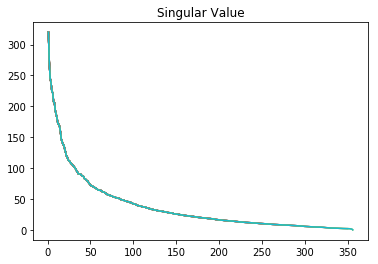

In [7]:
df_perf = pd.DataFrame()

for n_components in range(10, 400, 20):
    
        FN_WEIGHT = FD_WEIGHT + 'weight_SVD_n{0}.p'.format(n_components)

        # Create model
        model = SVD_Label(n_components=n_components)

        # Build
        model.build(universe_x=universe_desc, universe_y=universe_label)

        # Compile
        model.compile()

        # Fit
        model.fit(x_train, y_train, verbose=True)

        # Save
        model.save_model(FN_WEIGHT)
        
        # Load
        model.load_model(FN_WEIGHT)

        # Inference
        y_pred = model.predict(x_test)

        # Evaluate
        perc_match = (y_pred == y_test).sum() / y_test.shape[0]
        print('n {0}, acc {1}'.format(n_components, perc_match))
        
        df_perf = df_perf.append(pd.DataFrame({'n_components': [n_components],
                                               'accuracy': [perc_match]}))
        
        
        

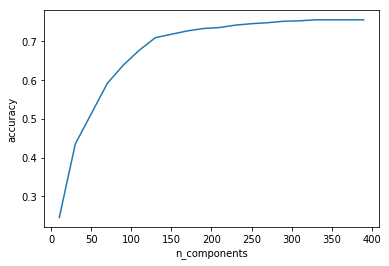

In [8]:
sns.lineplot(x='n_components', y='accuracy', data=df_perf)

In [9]:
param_optim = {'n_components': 300}

# Train NMF Labeller

In [ ]:
df_perf = pd.DataFrame()

for n_components in range(10, 356, 20):
    
        FN_WEIGHT = FD_WEIGHT + 'weight_NMF_n{0}.p'.format(n_components)
        
        # Create model
        model = NMF_Label(n_components=n_components)

        # Build
        model.build(universe_x=universe_desc, universe_y=universe_label)

        # Compile
        model.compile()

        # Fit
        model.fit(x_train, y_train, verbose=True)

        # Save
        model.save_model(FN_WEIGHT)
        
        # Load
        model.load_model(FN_WEIGHT)

        # Inference
        y_pred = model.predict(x_test)

        # Evaluate
        perc_match = (y_pred == y_test).sum() / y_test.shape[0]
        print('n {0}, acc {1}'.format(n_components, perc_match))
        
        df_perf = df_perf.append(pd.DataFrame({'n_components': [n_components],
                                               'accuracy': [perc_match]}))
        
        
        

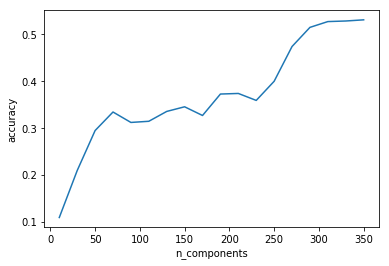

In [12]:
sns.lineplot(x='n_components', y='accuracy', data=df_perf)

In [13]:
param_optim = {'n_components': 300}

# Train WE Labeller

In [17]:
#df_perf = pd.DataFrame()

for embedding_size in (10, 20, 30, 40, 50, 60, 70):
    for num_sampled in (100,):#5, 10, 20, 30, 50):
    
        FN_WEIGHT = FD_WEIGHT + 'weight_WE_emb{0}_nce{1}.p'.format(embedding_size, num_sampled)

        # Create model
        model = WE_Label(vocabulary_size=len(universe_desc),
                         label_size=len(universe_label),
                         embedding_size=embedding_size)

        # Build
        model.build(universe_x=universe_desc, universe_y=universe_label)

        # Compile
        model.compile(num_sampled=num_sampled)     # num_samples:   no. of negative samples in tf.nn.nce_loss


        model.fit(x_train, y_train, verbose=True)

        # Save
        model.save_model(FN_WEIGHT)

        # Load
        model.load_model(FN_WEIGHT)

        # Inference
        y_pred = model.predict(x_test)

        # Evaluate
        perc_match = (y_pred == y_test).sum() / y_test.shape[0]
        print('emb {0}, nce {1}, acc {2}'.format(embedding_size, num_sampled, perc_match))
        
        df_perf = df_perf.append(pd.DataFrame({'embedding_size': [embedding_size],
                                               'num_sampled': [num_sampled],
                                               'accuracy': [perc_match]}))        
        
        
        

Initialized
 45400/100000 [============>.................] - ETA: 3:59 - loss: 0.5710 - val loss: 2.9195 - accuracy: 0.9375 - val accuracy: 0.7500
Plateau reached.
INFO:tensorflow:Restoring parameters from ./ckpt/WE_Label-14020

Reduce lr to 0.0005000000237487257
 78500/100000 [======================>.......] - ETA: 1:33 - loss: 0.7265 - val loss: 3.0012 - accuracy: 1.0000 - val accuracy: 0.7431
Plateau reached.
INFO:tensorflow:Restoring parameters from ./ckpt/WE_Label-14020

Reduce lr to 0.0002500000118743628
100000/100000 [==============================] - 433s 4ms/step - loss: 0.9611 - val loss: 2.6706 - accuracy: 0.8750 - val accuracy: 0.7514
INFO:tensorflow:Restoring parameters from ./ckpt/WE_Label-14020
emb 10, nce 100, acc 0.7058096415327565
Initialized
 37300/100000 [==========>...................] - ETA: 4:37 - loss: 0.6539 - val loss: 2.5736 - accuracy: 0.9688 - val accuracy: 0.7527
Plateau reached.
INFO:tensorflow:Restoring parameters from ./ckpt/WE_Label-13960

Reduce lr to

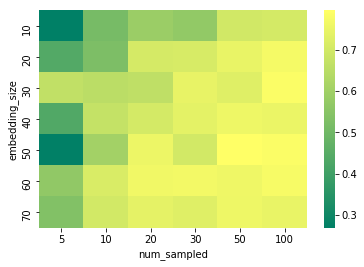

In [18]:
sns.heatmap(df_perf.pivot(index='embedding_size', columns='num_sampled', values='accuracy'), cmap='summer')

In [21]:
param_optim = {'embedding_size': 50,
               'num_sampled': 50}